In [189]:
# IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.signal import medfilt
from scipy.spatial.transform import Rotation as R
from typing import List, Tuple
import os

from IPython.display import HTML

%matplotlib inline

In [29]:
# HELPER FUNCTIONS

# load dataset
def load_data(data_path, key_path):
    data = np.load(data_path, allow_pickle=True)
    key = np.load(key_path, allow_pickle=True).item()
    print("Loaded data and key.")
    print("Data shape: ", data.shape)
    print("Key length: ", len(key))
    return data, key

# plot force, position, and raw sensor data
def plot_initial_data(plot_data, plot_key):

    # plot force data over time
    force_fig, force_ax = plt.subplots(1,1)
    force_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["Fx"]], label="Fx")
    force_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["Fy"]], label="Fy")
    force_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["Fz"]], label="Fz")
    force_ax.set_title("Force")
    force_ax.legend()
    plt.tight_layout()
    plt.show()

    # plot x,y,z location over time
    loc_fig, loc_ax = plt.subplots(1,1)
    loc_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["x_act"]], label="x")
    loc_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["y1_act"]], label="y")
    loc_ax.plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key["z_act"]], label="z")
    loc_ax.set_title("Location")
    loc_ax.legend()
    plt.tight_layout()
    plt.show()

    # plot all sensor data over time
    sensor_fig, sensor_ax = plt.subplots(3,12, figsize=(80,20))
    sensor_keys = []
    for k in list(plot_key.keys()):
        if 's' in k: # TODO: this might break if we add more columns to the dataset
            sensor_keys.append(k)
    k = 0
    for i in range(3):
        for j in range(12):
            cur_key = sensor_keys[k]
            sensor_ax[i,j].plot(plot_data[:, plot_key["time"]], plot_data[:, plot_key[cur_key]], label=cur_key)
            sensor_ax[i,j].set_title(cur_key)
            sensor_ax[i,j].set_ylim(-5000, 35000)
            k += 1
    plt.show()

def plot_single_sensor_data(input_data, input_key, sensor_to_plot):
    fig, ax = plt.subplots(3,1)
    ax[0].plot(input_data[:, input_key["time"]], input_data[:, input_key["Fz"]], label="Fz")
    ax[0].set_title("Fz")
    ax[1].plot(input_data[:, input_key["time"]], input_data[:, input_key["z_act"]], label="z")
    ax[1].set_title("z")
    ax[2].plot(input_data[:, input_key["time"]], input_data[:, input_key[sensor_to_plot]], label=sensor_to_plot)
    ax[2].set_title(sensor_to_plot)
    plt.tight_layout()
    plt.show()


Loaded data and key.
Data shape:  (8729, 51)
Key length:  51


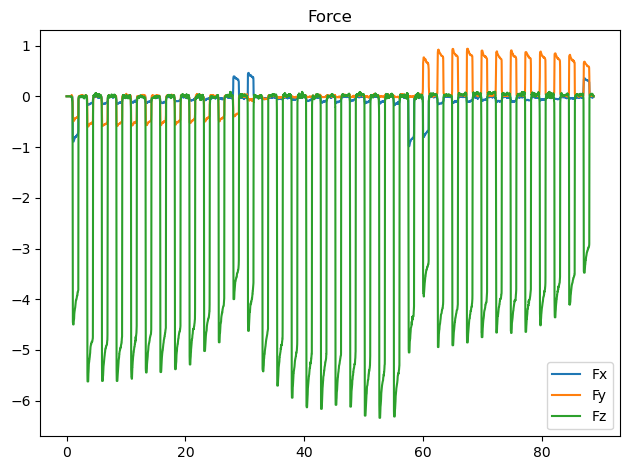

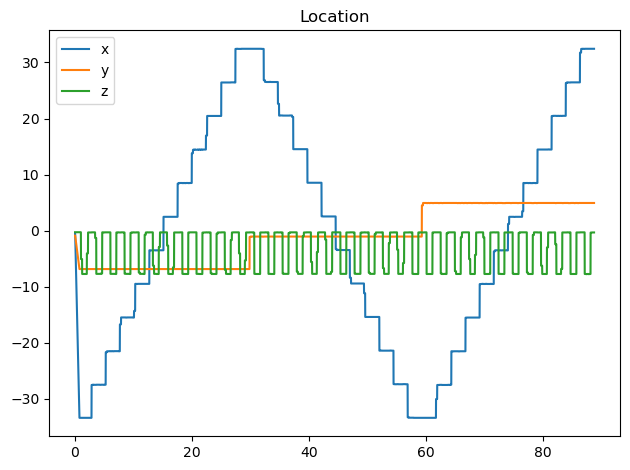

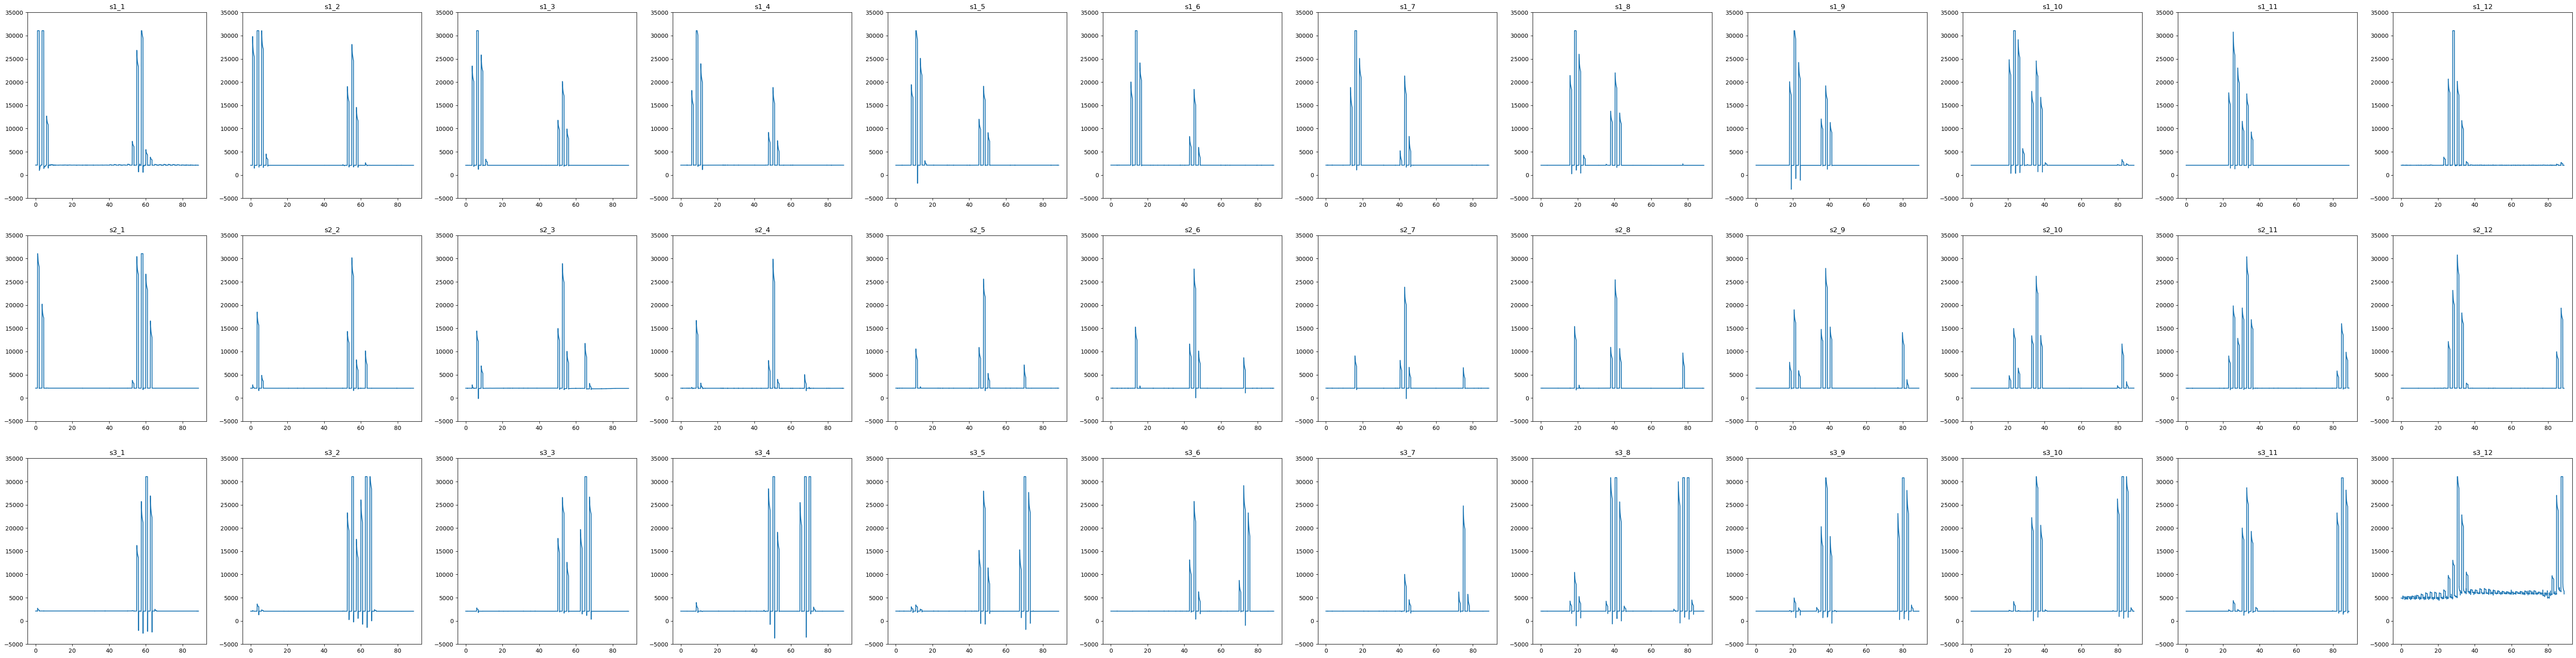

In [30]:
test_path = "data/2024-11-15_14-07-16.925178_FULLGRID_BP_COMBO"

# load data
data_path = os.path.join(test_path, "processed.npy")
key_path = os.path.join(test_path, "key.npy")
data, key = load_data(data_path, key_path)

plot_initial_data(data, key)

In [70]:
# ITERATE THROUGH TRAJ POINTS TO STORE DATA

traj_pts = np.linspace(1,36,36)
# trajectory zigzags, so we need to reverse every other row
sensor_traj = ['s1_1', 's1_2', 's1_3', 's1_4', 's1_5', 's1_6', 's1_7', 's1_8', 's1_9', 's1_10', 's1_11', 's1_12',
            's2_12', 's2_11', 's2_10', 's2_9', 's2_8', 's2_7', 's2_6', 's2_5', 's2_4', 's2_3', 's2_2', 's2_1',
            's3_1', 's3_2', 's3_3', 's3_4', 's3_5', 's3_6', 's3_7', 's3_8', 's3_9', 's3_10', 's3_11', 's3_12']
# regular sensor order does not zigzag
sensor_list = ['s1_1', 's1_2', 's1_3', 's1_4', 's1_5', 's1_6', 's1_7', 's1_8', 's1_9', 's1_10', 's1_11', 's1_12',
                's2_1', 's2_2', 's2_3', 's2_4', 's2_5', 's2_6', 's2_7', 's2_8', 's2_9', 's2_10', 's2_11', 's2_12',
                's3_1', 's3_2', 's3_3', 's3_4', 's3_5', 's3_6', 's3_7', 's3_8', 's3_9', 's3_10', 's3_11', 's3_12']

max_pressures = np.zeros((3,12,len(traj_pts)))
max_pressures_idx = np.zeros((3,12,len(traj_pts)))
median_pressures = np.zeros((3,12,len(traj_pts)))
for i in range(36): # for each point in trajectory
    pt_idx = i+1
    s = 0
    point_data = data[data[:, key['point_idx']] == pt_idx]
    for j in range(3):
        for k in range(12):
            cur_key = sensor_list[s]
            max_pressures[j,k,i] = np.max(point_data[:, key[cur_key]])
            max_pressures_idx[j,k,i] = np.argmax(point_data[:, key[cur_key]])
            median_pressures[j,k,i] = np.median(point_data[:, key[cur_key]])
            # print([s, j, k, cur_key])
            s+=1

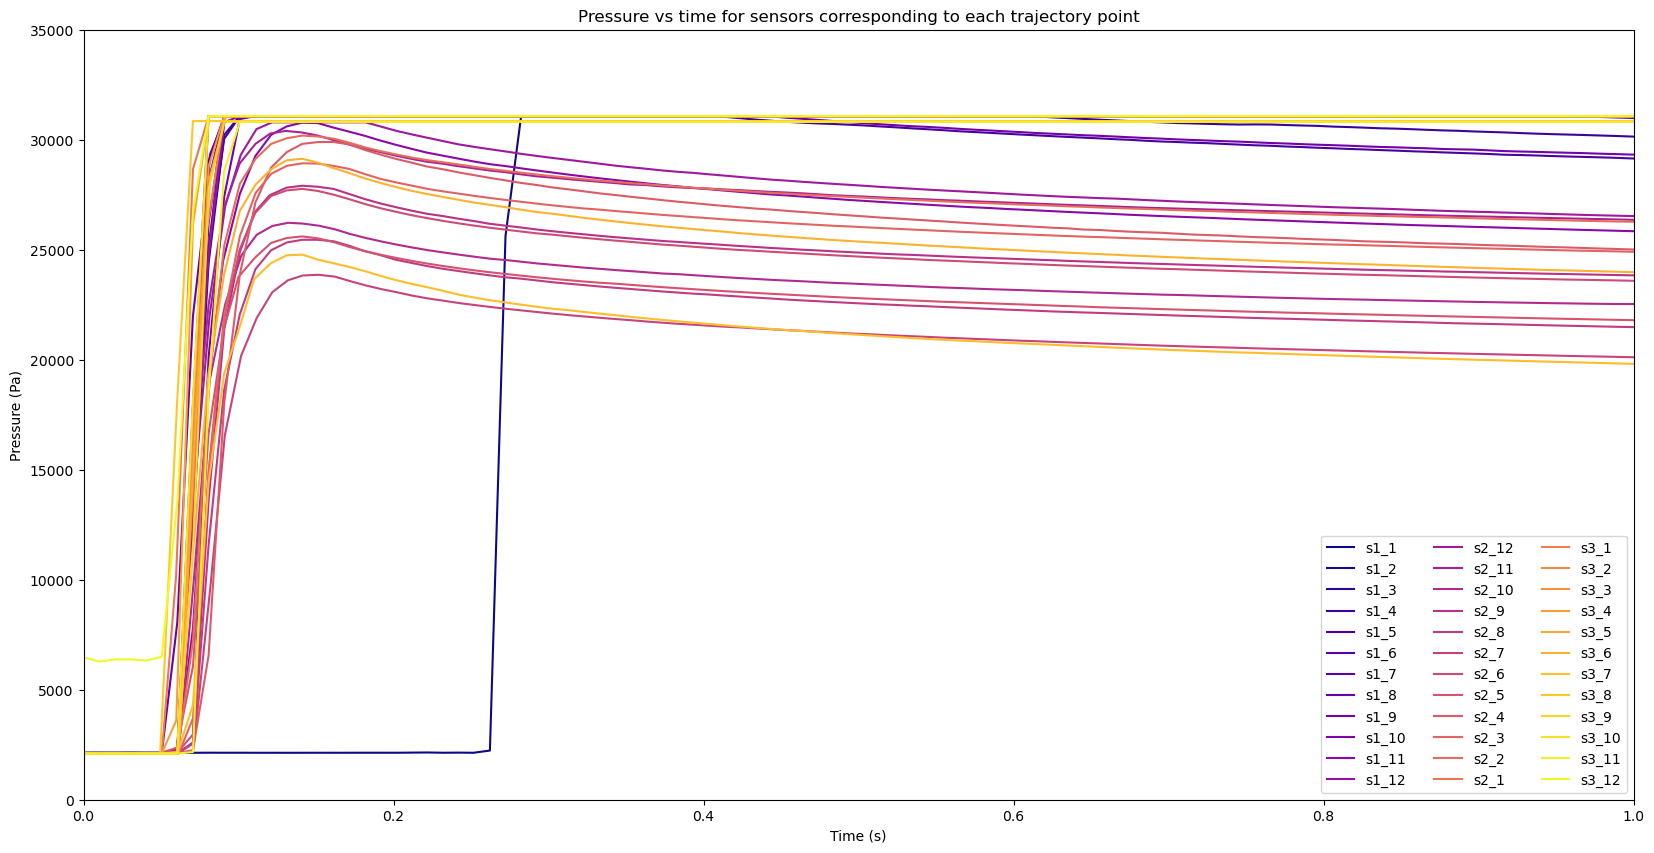

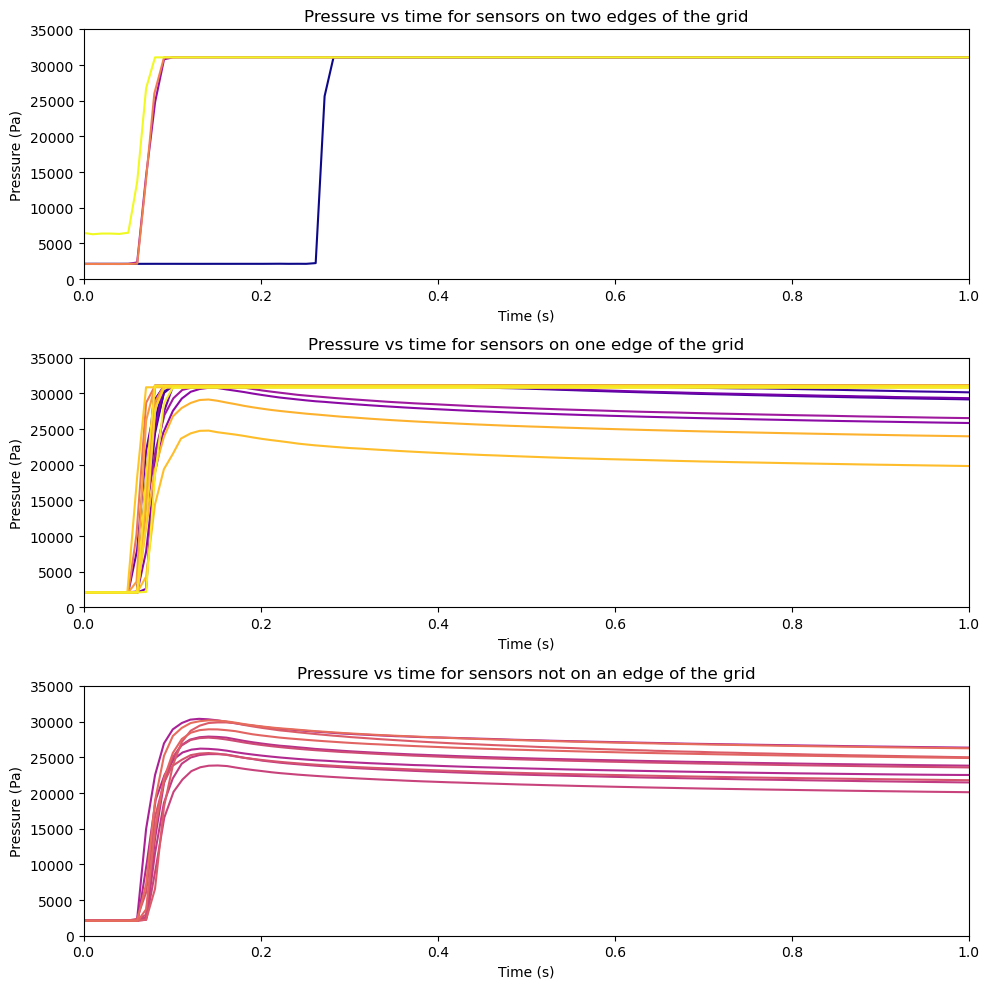

In [190]:
# CONSISTENCY OF PEAK ACTIVATIONS

# sort by boundary conditions
two_edge = ['s1_1', 's1_12', 's3_1', 's3_12']
one_edge = ['s1_2', 's1_3', 's1_4', 's1_5', 's1_6', 's1_7', 's1_8', 's1_9', 's1_10', 's1_11',
            's2_1', 's2_12',
            's3_2', 's3_3', 's3_4', 's3_5', 's3_6', 's3_7', 's3_8', 's3_9', 's3_10', 's3_11']
no_edge = ['s2_2', 's2_3', 's2_4', 's2_5', 's2_6', 's2_7', 's2_8', 's2_9', 's2_10', 's2_11']



# plot all peaks together on one figure, sort by boundary conditions in a second figure
cmap = plt.get_cmap('plasma')
colors = cmap(np.linspace(0, 1, 36))
fig1, ax1 = plt.subplots(1,1, figsize=(20,10))
fig2, ax2 = plt.subplots(3,1, figsize=(10,10))
for i in range(36):
    s = sensor_traj[i]
    p = i+1
    point_data = data[data[:, key['point_idx']] == p]
    point_data[:,key['time']] = point_data[:,key['time']] - point_data[0,key['time']]
    ax1.plot(point_data[:, key['time']], point_data[:, key[s]], label=s, color=colors[i])
    if s in two_edge:
        ax2[0].plot(point_data[:, key['time']], point_data[:, key[s]], label=s, color=colors[i])
    elif s in one_edge:
        ax2[1].plot(point_data[:, key['time']], point_data[:, key[s]], label=s, color=colors[i])
    elif s in no_edge:
        ax2[2].plot(point_data[:, key['time']], point_data[:, key[s]], label=s, color=colors[i])

ax1.legend(ncol=3)
ax1.set_xlim(0, 1.0)
ax1.set_ylim(0, 35000)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Pressure (Pa)")
ax1.set_title("Pressure vs time for sensors corresponding to each trajectory point")

# legends are too large for these plots
# ax2[0].legend()
ax2[0].set_xlim(0, 1.0)
ax2[0].set_ylim(0, 35000)
ax2[0].set_xlabel("Time (s)")
ax2[0].set_ylabel("Pressure (Pa)")
ax2[0].set_title("Pressure vs time for sensors on two edges of the grid")
# ax2[1].legend()
ax2[1].set_xlim(0, 1.0)
ax2[1].set_ylim(0, 35000)
ax2[1].set_xlabel("Time (s)")
ax2[1].set_ylabel("Pressure (Pa)")
ax2[1].set_title("Pressure vs time for sensors on one edge of the grid")
# ax2[2].legend()
ax2[2].set_xlim(0, 1.0)
ax2[2].set_ylim(0, 35000)
ax2[2].set_xlabel("Time (s)")
ax2[2].set_ylabel("Pressure (Pa)")
ax2[2].set_title("Pressure vs time for sensors not on an edge of the grid")

plt.tight_layout()
plt.show()

In [191]:
# PLOT PEAK AND MEDIAN PRESSURES AS TRAJECTORY PROGRESSES

# calculate distances
# sensor indexing: si_j = row i, column j
col_coords = np.linspace(-33,33,12)
row_coords = np.linspace(-6,6,3)
COLS, ROWS = np.meshgrid(col_coords, row_coords)

# map presure values to dot sizes
def pressure_to_size(pressure):
    if (pressure < 0):
        return 0
    else:
        return 100 + 1000*(pressure/35000)

# individual plots for each point
# for i in range(36):
#     pt_to_plot = i+1
#     fig, ax = plt.subplots(1,1, figsize=(12,4))
#     sizes = np.zeros((3,12))
#     for i in range(3):
#         for j in range(12):
#             sizes[i,j] = pressure_to_size(max_pressures[i,j,pt_to_plot-1])
#     cax1 = ax.scatter(COLS, ROWS, s=sizes, c=max_pressures[:,:,pt_to_plot-1], cmap='viridis', clim=(0,35000))
#     cbar = fig.colorbar(cax1, ax=ax)
#     s = 0
#     for i in range(3):
#         for j in range(12):
#             cur_key = sensor_list[s]
#             if i==1:
#                 j = 11-j
#             # ax.scatter(COLS[i,j], ROWS[i,j], s=100, c=max_pressures[i,j,pt_to_plot-1], cmap='viridis')
#             if s==(pt_to_plot-1):
#                 ax.scatter(COLS[i,j], ROWS[i,j], s=50, c='r', marker='o')
#                 # ax.text(COLS[i,j], ROWS[i,j], cur_key, fontsize=12)
#             s+=1
#     cbar.set_label("Pressure (Pa)")
#     ax.set_title("Pressure distribution at trajectory point " + str(pt_to_plot))
#     ax.set_xlabel("X (mm)")
#     ax.set_xlim(-40,40)
#     ax.set_ylabel("Y (mm)")
#     ax.set_ylim(-10,10)
#     plt.tight_layout()
#     plt.show()

# make this an animation
fig, ax = plt.subplots(1,1, figsize=(12,4))
cax1 = ax.scatter(COLS, ROWS, c=max_pressures[:,:,0], cmap='viridis', clim=(0,35000))
cbar = fig.colorbar(cax1, ax=ax)
cbar.set_label("Pressure (Pa)")

def update(pt_to_plot):
    ax.clear()
    # cbar.remove()
    sizes = np.zeros((3,12))
    for i in range(3):
        for j in range(12):
            sizes[i,j] = pressure_to_size(max_pressures[i,j,pt_to_plot-1])
    cax1 = ax.scatter(COLS, ROWS, s=sizes, c=max_pressures[:,:,pt_to_plot-1], cmap='viridis', clim=(0,35000))
    # cbar = fig.colorbar(cax1, ax=ax)
    # cbar.set_label("Pressure (Pa)")
    s = 0
    for i in range(3):
        for j in range(12):
            cur_key = sensor_list[s]
            if i==1:
                j = 11-j
            # ax.scatter(COLS[i,j], ROWS[i,j], s=100, c=max_pressures[i,j,pt_to_plot-1], cmap='viridis')
            if s==(pt_to_plot-1):
                ax.scatter(COLS[i,j], ROWS[i,j], s=50, c='r', marker='o')
                # ax.text(COLS[i,j], ROWS[i,j], cur_key, fontsize=12)
            s+=1
    ax.set_title("Pressure distribution at trajectory point " + str(pt_to_plot))
    ax.set_xlabel("X (mm)")
    ax.set_xlim(-40,40)
    ax.set_ylabel("Y (mm)")
    ax.set_ylim(-10,10)
    plt.tight_layout()

ani = animation.FuncAnimation(fig, update, frames=range(1,37), interval=300, repeat=False)
# ani.save('full_grid_pressure_distribution.gif', writer='imagemagick')
HTML(ani.to_html5_video())


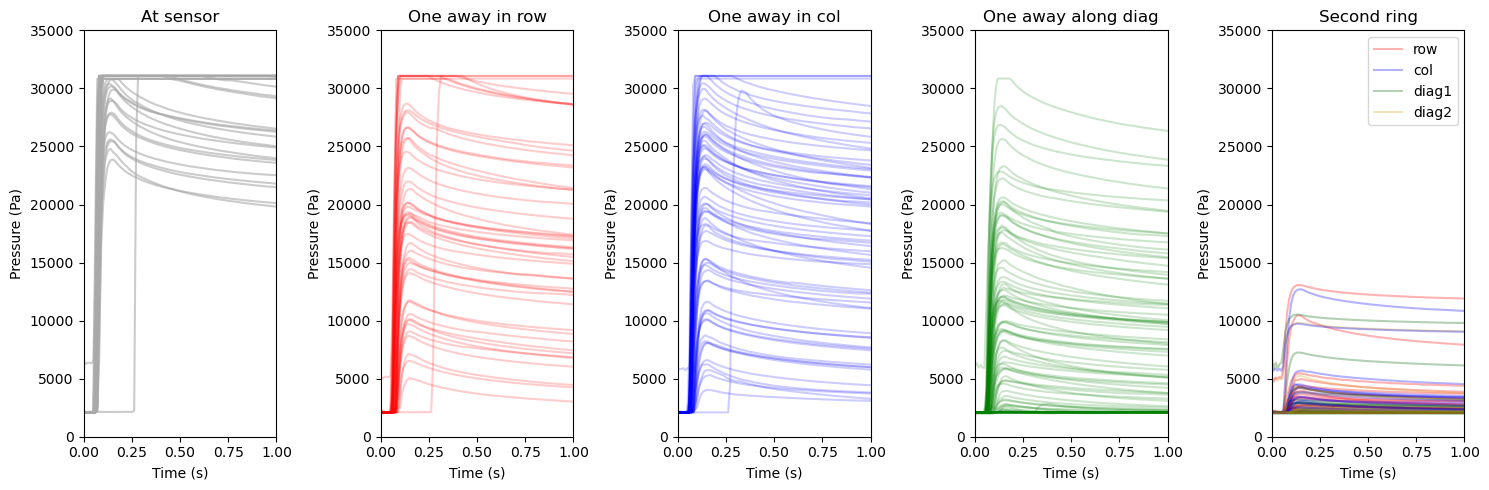

In [224]:
# COMPILE PEAKS FOR AT SENSOR, 1-AWAY, 2-AWAY, 3-AWAY FROM STIMULUS

# sensor indexing: si_j = row i, column j
rows = [1,2,3]
cols = [1,2,3,4,5,6,7,8,9,10,11,12]

one_hop_row = [[1,0],[-1,0]]
one_hop_col = [[0,1],[0,-1]]
one_hop = one_hop_row + one_hop_col

two_hop_row = [[2,0],[-2,0]]
two_hop_col = [[0,2],[0,-2]]
two_hop_diag = [[1,1],[1,-1],[-1,1],[-1,-1]]
two_hop = two_hop_row + two_hop_col + two_hop_diag


three_hop_col = [[0,3],[0,-3]]
three_hop_diag_one_row = [[1,2],[1,-2],[-1,2],[-1,-2]]
three_hop_diag_two_row = [[2,1],[2,-1],[-2,1],[-2,-1]]
three_hop = three_hop_col + three_hop_diag_one_row + three_hop_diag_two_row


fig, ax = plt.subplots(1,5, figsize=(15,5))

for i in range(36):
    s = sensor_traj[i]
    pt_to_plot = i+1
    point_data = data[data[:, key['point_idx']] == pt_to_plot]
    point_data[:,key['time']] = point_data[:,key['time']] - point_data[0,key['time']]

    # get row,col idx of current point
    if pt_to_plot < 13:
        row = 1
        col = pt_to_plot
    elif pt_to_plot < 25:
        row = 2
        col = 25-pt_to_plot
    else:
        row = 3
        col = pt_to_plot-24

    # for this point, plot pressures for sensors 1-away, 2-away, and 3-away

    # plot at sensor
    ax[0].plot(point_data[:, key['time']], point_data[:, key[s]], color='darkgrey', alpha=0.6)

    # plot 1-away
    for hop in one_hop_row:
        row_new = row + hop[0]
        col_new = col + hop[1]
        if row_new < 1 or row_new > 3 or col_new < 1 or col_new > 12:
            continue
        else:
            snew = 's'+str(row_new)+'_'+str(col_new)
            ax[1].plot(point_data[:, key['time']], point_data[:, key[snew]], color='r', alpha=0.2, label='row')
    for hop in one_hop_col:
        row_new = row + hop[0]
        col_new = col + hop[1]
        if row_new < 1 or row_new > 3 or col_new < 1 or col_new > 12:
            continue
        else:
            snew = 's'+str(row_new)+'_'+str(col_new)
            ax[2].plot(point_data[:, key['time']], point_data[:, key[snew]], color='b', alpha=0.2, label='col')
    for hop in two_hop_diag:
        row_new = row + hop[0]
        col_new = col + hop[1]
        if row_new < 1 or row_new > 3 or col_new < 1 or col_new > 12:
            continue
        else:
            snew = 's'+str(row_new)+'_'+str(col_new)
            ax[3].plot(point_data[:, key['time']], point_data[:, key[snew]], color='g', alpha=0.2, label='diag')

    # plot 2-away
    for hop in two_hop_row:
        row_new = row + hop[0]
        col_new = col + hop[1]
        if row_new < 1 or row_new > 3 or col_new < 1 or col_new > 12:
            continue
        else:
            snew = 's'+str(row_new)+'_'+str(col_new)
            ax[4].plot(point_data[:, key['time']], point_data[:, key[snew]], color='r', alpha=0.3, label='row')
    for hop in two_hop_col:
        row_new = row + hop[0]
        col_new = col + hop[1]
        if row_new < 1 or row_new > 3 or col_new < 1 or col_new > 12:
            continue
        else:
            snew = 's'+str(row_new)+'_'+str(col_new)
            ax[4].plot(point_data[:, key['time']], point_data[:, key[snew]], color='b', alpha=0.3, label='col')
    for hop in three_hop_diag_one_row:
        row_new = row + hop[0]
        col_new = col + hop[1]
        if row_new < 1 or row_new > 3 or col_new < 1 or col_new > 12:
            continue
        else:
            snew = 's'+str(row_new)+'_'+str(col_new)
            ax[4].plot(point_data[:, key['time']], point_data[:, key[snew]], color='darkgreen', alpha=0.3, label='diag1')
    for hop in three_hop_diag_two_row:
        row_new = row + hop[0]
        col_new = col + hop[1]
        if row_new < 1 or row_new > 3 or col_new < 1 or col_new > 12:
            continue
        else:
            snew = 's'+str(row_new)+'_'+str(col_new)
            ax[4].plot(point_data[:, key['time']], point_data[:, key[snew]], color='goldenrod', alpha=0.3, label='diag2')

ax[0].set_xlabel("Time (s)")
ax[0].set_xlim(0, 1.0)
ax[0].set_ylabel("Pressure (Pa)")
ax[0].set_ylim(0, 35000)
ax[0].set_title("At sensor")

ax[1].set_xlabel("Time (s)")
ax[1].set_xlim(0, 1.0)
ax[1].set_ylabel("Pressure (Pa)")
ax[1].set_ylim(0, 35000)
ax[1].set_title("One away in row")

ax[2].set_xlabel("Time (s)")
ax[2].set_xlim(0, 1.0)
ax[2].set_ylabel("Pressure (Pa)")
ax[2].set_ylim(0, 35000)
ax[2].set_title("One away in col")

ax[3].set_xlabel("Time (s)")
ax[3].set_xlim(0, 1.0)
ax[3].set_ylabel("Pressure (Pa)")
ax[3].set_ylim(0, 35000)
ax[3].set_title("One away along diag")

ax[4].set_xlabel("Time (s)")
ax[4].set_xlim(0, 1.0)
ax[4].set_ylabel("Pressure (Pa)")
ax[4].set_ylim(0, 35000)
ax[4].set_title("Second ring")
ax[4].legend(labels=['row', 'col', 'diag1', 'diag2'], loc='upper right')

plt.tight_layout()
plt.show()